In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41985")
client

<Client: 'tcp://127.0.0.1:41985' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os.path as op

from xgcm.grid import Grid
# import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset

import gcm_filters

import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/NA-wavelets/'
tdgs = '/tank/tdgs/tuchida/TWA/'
spec = '/tank/spectre/tuchida/NA-wavelets/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0
sreg = ['A','B','C','D','E','F']

xo = 50e3
ntheta = 36

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

##### $$-\Big\langle \big(\overline{u u'}^l - \overline{u}^l\overline{u'}^l\big)\overline{u'}^l_x + \big(\overline{uv'}^l - \overline{u}^l\overline{v'}^l + \overline{v u'}^l - \overline{v}^l\overline{u'}^l\big)\frac{\overline{u'}^l_y + \overline{v'}^l_x}{2} + \big(\overline{v v'}^l - \overline{v}^l\overline{v'}^l\big)\overline{v'}^l_y \Big\rangle$$

In [6]:
iiter = 1419120
dg = 1
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(
                           # YC=slice(15-dg/12,50+dg/12),
                           # YG=slice(15-dg/12,50+dg/12),
                           # XC=slice(273-dg/12,330+dg/12),
                           # XG=slice(273-dg/12,330+dg/12)
                          ).isel(time=0, Z=[18], Zl=[18], Zu=[18], Zp1=[18,19],
                                 YC=slice(1,-1),
                                 YG=slice(1,-1))
# if len(dsb.XG) > len(dsb.XC):
#      dsb = dsb.isel(XG=slice(None,-1))
# elif len(dsb.XG) < len(dsb.XC):
#      dsb = dsb.isel(XC=slice(1,None))  
# dsb = dsb.isel(YC=slice(1,-1),XC=slice(1,-1),
#                YG=slice(1,-1),XG=slice(1,-1))

coords={'X':{'center':'XC', 'left':'XG'}, 
        'Y':{'center':'YC', 'left':'YG'}}
grid = Grid(dsb, periodic=['X'],
            coords=coords)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [13]:
fs = 200
dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' % (iiter,fs))
                  )
dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' % (iiter,fs))
                  )
dsUV = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' % (iiter,fs)))
# dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' % (iiter,fs)))
# dsvup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' % (iiter,fs)))
dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup.zarr' % (iiter,fs)))
dsvup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp.zarr' % (iiter,fs)))

# # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu.zarr' % (iiter,fs)))
# # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv.zarr' % (iiter,fs)))
# # dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv.zarr' % (iiter,fs)))
# dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu.zarr' % (iiter,fs)))
# dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv.zarr' % (iiter,fs)))
dsu, dsUV, dsuup, dsvup

(<xarray.Dataset>
 Dimensions:  (XG: 1000, YC: 898, Z: 1, nmemb: 48)
 Coordinates:
   * XG       (XG) float32 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
   * YC       (YC) float32 -19.83 -19.75 -19.67 -19.58 ... 54.75 54.83 54.92
   * Z        (Z) float32 -452.4
   * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
 Data variables:
     u        (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:  (YC: 900, XG: 1000, Z: 1, YG: 900, XC: 1000)
 Coordinates: (12/23)
     Depth    (YC, XG) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
     PHrefC   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
   * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
   * XG       (XG) float32 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
   * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
   * YG       (YG) float32 -19.96 -19.87 -1

## Eddy $\Pi$

In [14]:
up = (dsu.u - dsUV.U)
vp = (dsv.v - dsUV.V)
upx = grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                'X', 
                # boundary='extend'
               ) / dsb.rA / dsb.drF / dsb.hFacC
vpy = grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                'Y', boundary='extend'
               ) / dsb.rA / dsb.drF / dsb.hFacC
upy = grid.interp(grid.interp(grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                        'Y', boundary='extend'
                                       ) / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,
                                                                           'Y',
                                                                           boundary='extend'
                                                                          ),
                              'Y', boundary='extend'),
                  'X', 
                  # boundary='extend'
                 )
vpx = grid.interp(grid.interp(grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                        'X', 
                                        # boundary='extend'
                                       ) / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',
                                                                           # boundary='extend'
                                                                          ),
                              'X', 
                              # boundary='extend'
                             ),
                  'Y', boundary='extend')
vpx

<xarray.DataArray (nmemb: 48, Z: 1, YC: 898, XC: 1000)>
dask.array<transpose, shape=(48, 1, 898, 1000), dtype=float32, chunksize=(1, 1, 199, 200), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.83 -19.75 -19.67 -19.58 ... 54.67 54.75 54.83 54.92
  * Z        (Z) >f4 -452.4
Dimensions without coordinates: nmemb

In [15]:
Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',
                                # boundary='extend'
                               )) * upx
       + .5*(grid.interp(grid.interp(dsvup.uvp,'Y',boundary='extend'),
                         'X',
                         # boundary='extend'
                        )
             - grid.interp(dsu.u, 
                           'X',
                           # boundary='extend'
                          ) 
             * grid.interp(vp,'Y',boundary='extend')
             + grid.interp(grid.interp(dsvup.vup,'X',
                                       # boundary='extend'
                                      ),
                           'Y',boundary='extend')
             - grid.interp(dsv.v,'Y',boundary='extend') 
             * grid.interp(up,'X',
                           # boundary='extend'
                          )              
            ) * (upy+vpx)
       + (dsuup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
      ).reset_coords(drop=True).mean('nmemb').compute()
Pi

<xarray.DataArray (Z: 1, YC: 898, XC: 1000)>
array([[[ 6.5699578e-11,  5.9444054e-11,  5.6140519e-11, ...,
          8.6000713e-11,  8.0515566e-11,  7.3420194e-11],
        [ 4.4792319e-11,  3.9447234e-11,  3.6738820e-11, ...,
          6.7461516e-11,  6.0103658e-11,  5.2149535e-11],
        [ 3.6682792e-11,  3.2719095e-11,  3.0171771e-11, ...,
          5.2425897e-11,  4.7241086e-11,  4.1754003e-11],
        ...,
        [-4.4750548e-10, -3.3805456e-10, -2.3226841e-10, ...,
         -7.1997336e-10, -6.3968381e-10, -5.4934324e-10],
        [-5.1453347e-10, -3.6194445e-10, -2.1636130e-10, ...,
         -9.8564057e-10, -8.2100032e-10, -6.6706773e-10],
        [-1.2170887e-10,  4.7258863e-12, -9.2283776e-12, ...,
         -1.6798084e-09, -9.9903541e-10, -4.5411044e-10]]], dtype=float32)
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.83 -19.75 -19.67 -19.58 ... 54.75 54.83 54.92
  * Z        (Z) float32 -452.4

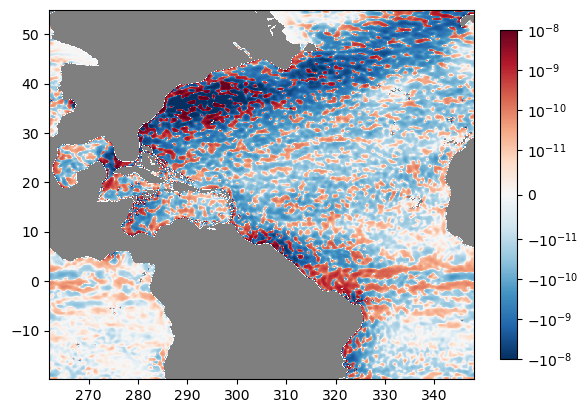

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.pcolormesh(dsb.XC, dsb.YC, Pi.where(dsb.maskC!=0.).isel(Z=0),
                   norm=clr.SymLogNorm(1e-11, vmin=-1e-8, vmax=1e-8),
                   cmap='RdBu_r',
                   rasterized=True
                  )
ax.pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC==0.).isel(Z=0),
              vmin=-2, vmax=2, cmap='binary', 
              rasterized=True
             )
ax.set_xlim([dsb.XC.min(), dsb.XC.max()])
ax.set_ylim([dsb.YC.min(), dsb.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/AluieFlux_Z0452_s=%03dkm_%010d_xgcm.pdf' 
                    % (int(fs*2), iiter)))

In [6]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  
# nd = 42
yystart = 0
ntimes[yystart,dd:][::3]

array([1419120, 1425600, 1432080, 1438560, 1445040, 1451520, 1458000,
       1464480, 1470960, 1477440, 1483920, 1490400, 1496880, 1503360,
       1509840, 1516320, 1522800, 1529280, 1535760, 1542240, 1548720,
       1555200, 1561680, 1568160, 1574640])

In [10]:
fs = 60

for iiter in ntimes[yystart,::3]:
    if iiter == ntimes[yystart,0]:
        dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(
                          ).isel(time=0, Z=[18], Zl=[18], Zu=[18], Zp1=[18,19],
                                 YC=slice(1,-1),
                                 YG=slice(1,-1))

        coords={'X':{'center':'XC', 'left':'XG'}, 
                'Y':{'center':'YC', 'left':'YG'}}
        grid = Grid(dsb, periodic=['X'],
                    coords=coords)
        
    dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr'
                                   % (iiter,fs))
                          )
    dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,fs))
                          )
    dsUV = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                    % (iiter,fs))
                           )
    dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup.zarr' 
                                     % (iiter,fs))
                            )
    dsvup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp.zarr' 
                                     % (iiter,fs))
                            )
        
    up = (dsu.u - dsUV.U)
    vp = (dsv.v - dsUV.V)
    upx = grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                    'X', 
                    # boundary='extend'
                   ) / dsb.rA / dsb.drF / dsb.hFacC
    vpy = grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                    'Y', boundary='extend'
                   ) / dsb.rA / dsb.drF / dsb.hFacC
    upy = grid.interp(grid.interp(grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                            'Y', boundary='extend'
                                           ) / dsb.rAz / dsb.drF 
                                  / grid.interp(dsb.hFacW,'Y',
                                                boundary='extend'
                                               ),
                                  'Y', boundary='extend'),
                      'X', 
                      # boundary='extend'
                     )
    vpx = grid.interp(grid.interp(grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                            'X', 
                                            # boundary='extend'
                                           ) / dsb.rAz / dsb.drF 
                                  / grid.interp(dsb.hFacS,'X',
                                                # boundary='extend'
                                               ),
                                  'X', 
                                  # boundary='extend'
                                 ),
                      'Y', boundary='extend')
    
    if iiter == ntimes[yystart,0]:
        Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',
                                        # boundary='extend'
                                       )) * upx
               + .5*(grid.interp(grid.interp(dsvup.uvp,'Y',boundary='extend'),
                                 'X',
                                 # boundary='extend'
                                )
                     - grid.interp(dsu.u, 
                                   'X',
                                   # boundary='extend'
                                  ) 
                     * grid.interp(vp,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsvup.vup,'X',
                                               # boundary='extend'
                                              ),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(up,'X',
                                   # boundary='extend'
                                  )              
                    ) * (upy+vpx)
               + (dsuup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
              ).reset_coords(drop=True).mean('nmemb').compute()
    else:
        Pi = xr.concat([Pi, -((dsuup.uup - grid.interp(dsu.u*up,'X',
                                        # boundary='extend'
                                       )) * upx
               + .5*(grid.interp(grid.interp(dsvup.uvp,'Y',boundary='extend'),
                                 'X',
                                 # boundary='extend'
                                )
                     - grid.interp(dsu.u, 
                                   'X',
                                   # boundary='extend'
                                  ) 
                     * grid.interp(vp,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsvup.vup,'X',
                                               # boundary='extend'
                                              ),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(up,'X',
                                   # boundary='extend'
                                  )              
                    ) * (upy+vpx)
               + (dsuup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
              ).reset_coords(drop=True).mean('nmemb').compute()
                       ], 'time')
        
Pi

<xarray.DataArray (time: 25, Z: 1, YC: 898, XC: 1000)>
array([[[[-1.89529057e-12,  1.21868097e-11,  2.37867226e-11, ...,
          -2.50833399e-11, -1.98422945e-11, -1.29105060e-11],
         [-1.99772750e-11, -1.26762533e-11, -8.47270778e-12, ...,
          -3.58842123e-11, -3.28358105e-11, -2.74037928e-11],
         [-1.60748428e-11, -1.83695524e-11, -2.16833496e-11, ...,
          -8.89450753e-12, -1.18463355e-11, -1.41426827e-11],
         ...,
         [ 1.00358589e-10, -5.96440952e-12, -3.17847727e-11, ...,
           4.72848816e-10,  3.54278967e-10,  2.32304773e-10],
         [ 3.79794862e-10,  4.44230625e-10,  4.80476159e-10, ...,
           2.77522536e-11,  1.77052553e-10,  2.90736185e-10],
         [ 2.33740000e-10,  4.94609298e-10,  7.06927350e-10, ...,
          -6.11073192e-10, -2.94076707e-10, -2.78195435e-11]]],


       [[[ 4.19648032e-11,  4.22759917e-11,  4.10162182e-11, ...,
           2.57996072e-11,  3.29996135e-11,  3.89193434e-11],
         [-8.41027161e-12, -1.08905098e-11, -1.17729229e-11, ...,
          -1.20061157e-11, -8.31359981e-12, -7.02863939e-12],
         [-3.26713344e-11, -3.58549614e-11, -3.70033205e-11, ...,
...
         [-8.25945534e-10, -2.25806786e-11,  5.35502920e-10, ...,
          -2.90831559e-09, -2.30798269e-09, -1.61377167e-09],
         [-1.02013253e-09,  3.13528092e-11,  7.89374788e-10, ...,
          -3.39922335e-09, -2.84421553e-09, -2.04691553e-09]]],


       [[[ 1.77045661e-13,  4.52617138e-13,  5.34553846e-13, ...,
          -1.42977860e-12, -9.85181880e-13, -3.52824974e-13],
         [ 4.07702518e-12,  4.36940978e-12,  3.89801429e-12, ...,
           7.31362616e-13,  1.83193066e-12,  3.10285326e-12],
         [ 6.54206246e-12,  7.47029782e-12,  7.43897305e-12, ...,
           1.51222578e-12,  2.96697736e-12,  4.83977095e-12],
         ...,
         [-8.95007901e-10, -8.16238355e-10, -6.34533925e-10, ...,
          -8.69398387e-10, -8.84706308e-10, -9.00744868e-10],
         [-1.48219759e-09, -1.42033496e-09, -1.18655785e-09, ...,
          -1.27766064e-09, -1.33042910e-09, -1.42328371e-09],
         [-1.86602933e-09, -1.79608373e-09, -1.54576230e-09, ...,
          -1.49755053e-09, -1.63819214e-09, -1.78884729e-09]]]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.83 -19.75 -19.67 -19.58 ... 54.75 54.83 54.92
  * Z        (Z) float32 -452.4
Dimensions without coordinates: time

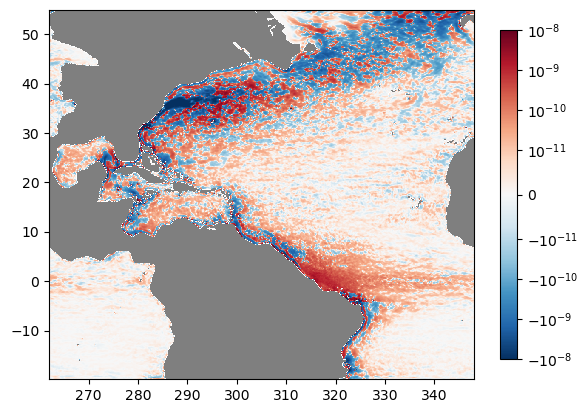

In [11]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.pcolormesh(dsb.XC, dsb.YC, Pi.where(dsb.maskC!=0.).isel(Z=0).mean('time'),
                   norm=clr.SymLogNorm(1e-11, vmin=-1e-8, vmax=1e-8),
                   cmap='RdBu_r',
                   rasterized=True
                  )
ax.pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC==0.).isel(Z=0),
              vmin=-2, vmax=2, cmap='binary', 
              rasterized=True
             )
ax.set_xlim([dsb.XC.min(), dsb.XC.max()])
ax.set_ylim([dsb.YC.min(), dsb.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\varepsilon_K$", fontsize=12)
plt.savefig(op.join(spec,'Figs/AluieFlux_Z0452_s=%03dkm_1967_xgcm.pdf' 
                    % (int(fs*2))))

## Total $\Pi$

In [8]:
ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
               'X', boundary='extend'
              ) / dsb.rA / dsb.drF / dsb.hFacC
vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
               'Y', boundary='extend'
              ) / dsb.rA / dsb.drF / dsb.hFacC
uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                       'Y', boundary='extend'
                                      ) 
                             / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                             'Y', boundary='extend'),
                 'X', boundary='extend')
vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                       'X', boundary='extend'
                                      ) 
                             / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                             'X', boundary='extend'),
                 'Y', boundary='extend')
vx

<xarray.DataArray (nmemb: 48, Z: 2, YC: 420, XC: 662)>
dask.array<transpose, shape=(48, 2, 420, 662), dtype=float32, chunksize=(1, 1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 273.1 273.2 273.3 273.4 273.4 ... 329.7 329.8 329.9 330.0
  * YC       (YC) >f4 15.0 15.08 15.17 15.25 15.33 ... 49.67 49.75 49.83 49.92
  * Z        (Z) >f4 -3.047 -452.4
Dimensions without coordinates: nmemb

In [9]:
Pi = -((dsuu.uu - grid.interp(dsu.u*dsu.u,'X',boundary='extend')) * ux
       + .5*(grid.interp(grid.interp(dsuv.uv,'Y',boundary='extend'),
                         'X',boundary='extend')
             - grid.interp(dsu.u, 'X',boundary='extend') 
             * grid.interp(dsv.v,'Y',boundary='extend')
             + grid.interp(grid.interp(dsuv.vu,'X',boundary='extend'),
                           'Y',boundary='extend')
             - grid.interp(dsv.v,'Y',boundary='extend') 
             * grid.interp(dsu.u,'X',boundary='extend')              
            ) * (uy+vx)
       + (dsuu.vv - grid.interp(dsv.v*dsv.v,'Y',boundary='extend')) * vy
      ).reset_coords(drop=True).mean('nmemb').compute()
Pi

<xarray.DataArray (Z: 2, YC: 420, XC: 662)>
array([[[            nan,             nan,             nan, ...,
          1.96312966e-10,  1.95259656e-10, -4.69373984e-10],
        [            nan,             nan,             nan, ...,
          1.98578029e-10, -1.02886942e-10, -2.78185586e-10],
        [            nan,             nan,             nan, ...,
          1.74309803e-10, -1.02576864e-10, -3.30778849e-10],
        ...,
        [-2.15388113e-07, -1.92327132e-08,  6.00173555e-09, ...,
         -4.27231974e-08, -5.43634719e-08, -5.87685385e-08],
        [ 1.06569559e-07,  7.76462183e-09,  1.71864283e-08, ...,
          1.99797174e-08,  3.45011451e-08,  3.57650869e-08],
        [ 1.64720859e-07, -3.84468137e-08, -5.84735815e-09, ...,
          6.19020781e-08,  8.95997729e-08,  1.02099278e-07]],

       [[            nan,             nan,             nan, ...,
          1.64551428e-11, -3.24115626e-12, -2.19087023e-11],
        [            nan,             nan,             nan, ...,
          1.27051069e-11,  2.53149324e-11, -1.56271194e-11],
        [            nan,             nan,             nan, ...,
          1.84100443e-11,  6.41427189e-11,  1.70118364e-11],
        ...,
        [            nan,             nan,             nan, ...,
         -4.85962603e-09, -6.13530204e-09, -5.80276804e-09],
        [            nan,             nan,             nan, ...,
          2.30814548e-10,  1.59447178e-09,  2.37356246e-09],
        [            nan,             nan,             nan, ...,
          4.09222745e-09,  7.95706523e-09,  1.14566845e-08]]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 273.1 273.2 273.3 273.4 ... 329.7 329.8 329.9 330.0
  * YC       (YC) float32 15.0 15.08 15.17 15.25 ... 49.67 49.75 49.83 49.92
  * Z        (Z) float32 -3.047 -452.4

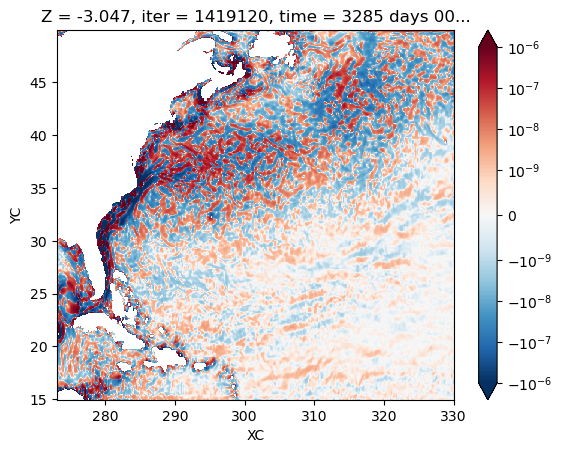

In [10]:
Pi.where(dsb.maskC!=0.).isel(Z=0).plot(rasterized=True, 
                                       norm=clr.SymLogNorm(1e-9, vmin=-1e-6, vmax=1e-6))

In [28]:
scale_min = 15e3

for iiter in ntimes[0,dd:][::3]:
    
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.concatenate((np.arange(scale_min,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk}
                                 ).isel(Z=1)
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk}
                                 ).isel(Z=1)
        dsUV = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                    % (iiter,int(filter_scale*1e-3))
                                   )
                           ).chunk({"YC":ychunk,"XC":xchunk,
                                    "YG":ychunk,"XG":xchunk}
                                  ).isel(Z=1)
        # dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' 
        #                              % (iiter,int(filter_scale*1e-3))
        #                             )
        #                     ).chunk({"YC":ychunk,"XC":xchunk})
        # dsvup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' 
        #                              % (iiter,int(filter_scale*1e-3))
        #                             )
        #                     ).chunk({"YC":ychunk,"XC":xchunk})
        dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup.zarr' 
                                     % (iiter,int(filter_scale*1e-3)))
                            ).chunk({"YC":ychunk,"XC":xchunk})
        dsuvp = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp.zarr' 
                                     % (iiter,int(filter_scale*1e-3)))
                            ).chunk({"YG":ychunk,"XG":xchunk})
        
        up = (dsu.u - dsUV.U).reset_coords(drop=True)
        vp = (dsv.v - dsUV.V).reset_coords(drop=True)
        
        upx = (grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                         'X', boundary='extend'
                        ) / dsb.rA / dsb.drF / dsb.hFacC
              ).reset_coords(drop=True)
        vpy = (grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                         'Y', boundary='extend'
                        ) / dsb.rA / dsb.drF / dsb.hFacC
              ).reset_coords(drop=True)
        upy = grid.interp(grid.interp(grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                                'Y', boundary='extend'
                                               ) / dsb.rAz / dsb.drF 
                                      / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                      'Y', boundary='extend'),
                          'X', boundary='extend').reset_coords(drop=True)
        vpx = grid.interp(grid.interp(grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                                'X', boundary='extend'
                                               ) / dsb.rAz / dsb.drF 
                                      / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                      'X', boundary='extend'),
                          'Y', boundary='extend').reset_coords(drop=True)
        
        # Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',boundary='extend')) * upx
        #        + .5*(dsuup.uvp - grid.interp(dsu.u,'X',boundary='extend')
        #              * grid.interp(vp,'Y',boundary='extend')
        #              + dsvup.vup - grid.interp(dsv.v,'Y',boundary='extend')
        #              * grid.interp(up,'X',boundary='extend')
        #             ) * (upy+vpx)
        #        + (dsvup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
        #       ).reset_coords(drop=True)
        Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',boundary='extend')
               ) * upx
               + .5*(grid.interp(grid.interp(dsuvp.uvp,'Y',boundary='extend'),
                                 'X',boundary='extend')
                     - grid.interp(dsu.u, 'X',boundary='extend') 
                     * grid.interp(vp,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsuvp.vup,'X',boundary='extend'),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(up,'X',boundary='extend')              
                    ) * (upy+vpx)
               + (dsuup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')
                 ) * vpy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,dd]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, 
        #                                                         vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        dsuup.close(); dsuvp.close()
        dsu.close(); dsv.close(); dsUV.close()
        del Pi
        
    print(iiter)

1419120


ValueError: conflicting sizes for dimension 'YC': length 420 on <this-array> and length 898 on {'XC': 'XC', 'YC': 'YC', 'Z': 'drF', 'nmemb': <this-array>} - does your grid ufunc correctly trim off the same number of elements which were added by padding using boundary_width={'X': (0, 1)}?

In [9]:
for iiter in ntimes[0,::3]:
    
    if iiter == ntimes[0,0]:
        ds120 = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                                     % (iiter,int(60))
                                    )
                            ).isel(YC=slice(None,-1),XC=slice(None,-2)
                                  ).chunk({"YC":ychunk,"XC":xchunk})
        ds200 = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                                     % (iiter,int(100))
                                    )
                            ).isel(YC=slice(None,-1),XC=slice(None,-2)
                                  ).chunk({"YC":ychunk,"XC":xchunk})
        ds400 = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                                     % (iiter,int(200))
                                    )
                            ).isel(YC=slice(None,-1),XC=slice(None,-2)
                                  ).chunk({"YC":ychunk,"XC":xchunk})
    else:
        ds120 = xr.concat([ds120, xr.open_zarr(op.join(savedir,
                                                       'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                                                       % (iiter,int(60))
                                                      )
                                              ).isel(YC=slice(None,-1),
                                                     XC=slice(None,-2)
                                                    ).chunk({"YC":ychunk,"XC":xchunk})
                          ], 'time')
        ds200 = xr.concat([ds200, xr.open_zarr(op.join(savedir,
                                                       'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                                                       % (iiter,int(100))
                                                      )
                                              ).isel(YC=slice(None,-1),
                                                     XC=slice(None,-2)
                                                    ).chunk({"YC":ychunk,"XC":xchunk})
                          ], 'time')
        ds400 = xr.concat([ds400, xr.open_zarr(op.join(savedir,
                                                       'Filtered/%010d/%03dkm/Pi_diag.zarr' 
                                                       % (iiter,int(200))
                                                      )
                                              ).isel(YC=slice(None,-1),
                                                     XC=slice(None,-2)
                                                    ).chunk({"YC":ychunk,"XC":xchunk})
                          ], 'time')
        
    print(iiter)
    
ds400

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


<xarray.Dataset>
Dimensions:  (time: 25, nmemb: 48, Z: 2, YC: 419, XC: 660)
Coordinates:
  * XC       (XC) float32 273.1 273.2 273.3 273.4 ... 329.6 329.6 329.7 329.8
  * YC       (YC) float32 15.0 15.08 15.17 15.25 ... 49.58 49.67 49.75 49.83
  * Z        (Z) float32 -3.047 -452.4
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Dimensions without coordinates: time
Data variables:
    Pi       (time, nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 1, 200, 200), meta=np.ndarray>

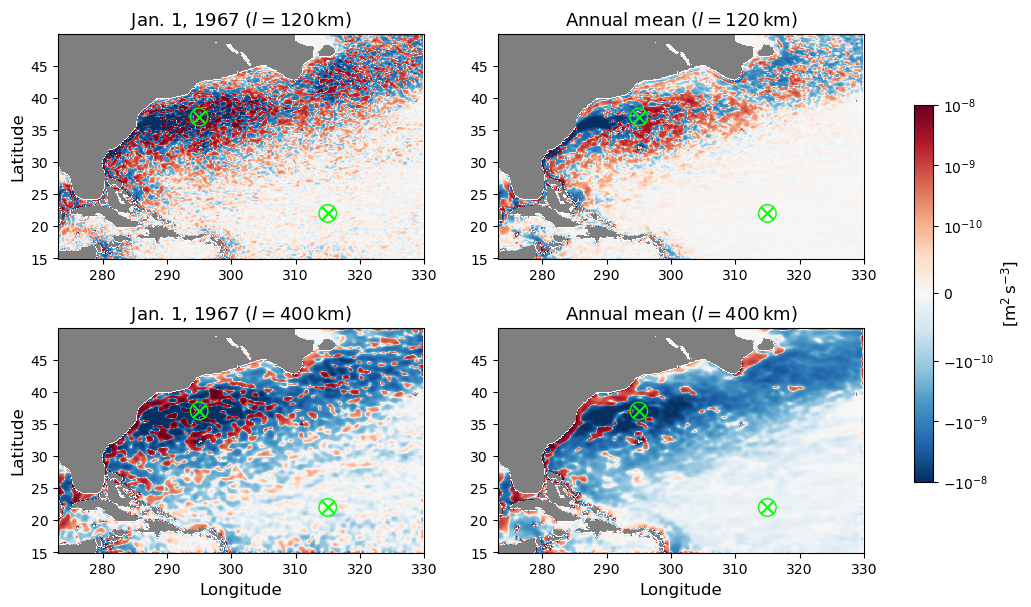

In [10]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(ds120.XC, ds120.YC, ds120.Pi.isel(time=0,Z=1).mean('nmemb'),
                          rasterized=True, cmap='RdBu_r',
                          norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                         )
axes[0,1].pcolormesh(ds120.XC, ds120.YC, ds120.Pi.isel(Z=1).mean(['time','nmemb']),
                     rasterized=True, cmap='RdBu_r',
                     norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                    )
axes[1,0].pcolormesh(ds400.XC, ds400.YC, ds400.Pi.isel(time=0,Z=1).mean('nmemb'),
                     rasterized=True, cmap='RdBu_r',
                     norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                    )
axes[1,1].pcolormesh(ds400.XC, ds400.YC, ds400.Pi.isel(Z=1).mean(['time','nmemb']),
                     rasterized=True, cmap='RdBu_r',
                     norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                    )

axes[0,0].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=1),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[0,1].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=1),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[1,0].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=1),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[1,1].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=1),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )

for reg in range(6):
    if reg == 0 or reg == 5:
        axes[0,0].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[0,0].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')
        axes[0,1].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[0,1].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')
        axes[1,0].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[1,0].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')
        axes[1,1].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[1,1].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)

axes[0,0].set_title(r"Jan. 1, 1967 ($l=120\,$km)", fontsize=13)
axes[0,1].set_title(r"Annual mean ($l=120\,$km)", fontsize=13)
axes[1,0].set_title(r"Jan. 1, 1967 ($l=400\,$km)", fontsize=13)
axes[1,1].set_title(r"Annual mean ($l=400\,$km)", fontsize=13)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=.7)
cbar.set_label(r"[m$^2\,$s$^{-3}$]", fontsize=12)

plt.savefig(op.join(spec,'Figs/Aluie-Pi-diag_Z452.pdf'))

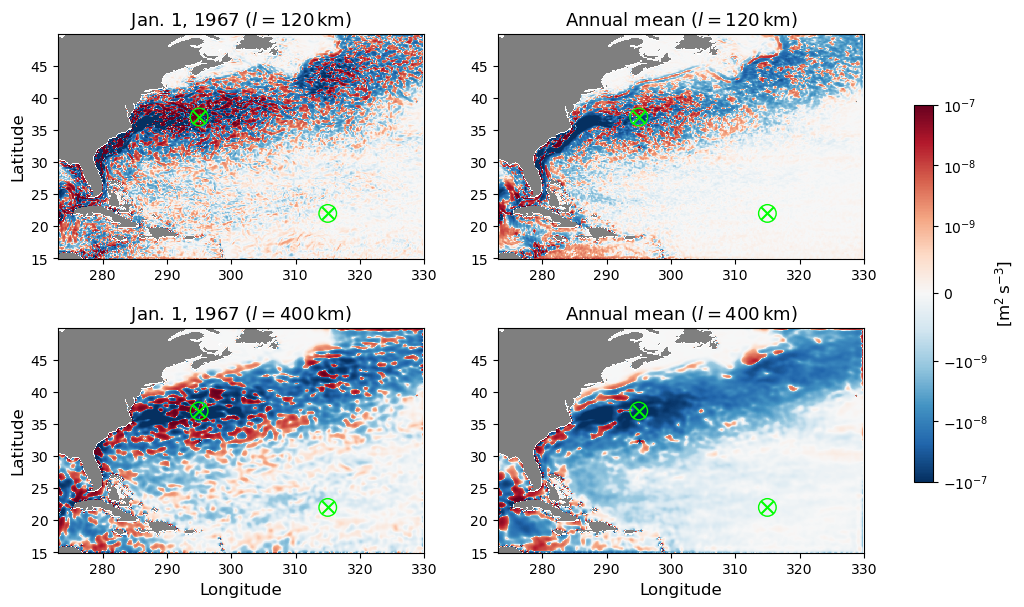

In [15]:
fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(ds120.XC, ds120.YC, ds120.Pi.isel(time=0,Z=0).mean('nmemb'),
                          rasterized=True, cmap='RdBu_r',
                          norm=clr.SymLogNorm(1e-9, vmin=-1e-7, vmax=1e-7)
                         )
axes[0,1].pcolormesh(ds120.XC, ds120.YC, ds120.Pi.isel(Z=0).mean(['time','nmemb']),
                     rasterized=True, cmap='RdBu_r',
                     norm=clr.SymLogNorm(1e-9, vmin=-1e-7, vmax=1e-7)
                    )
axes[1,0].pcolormesh(ds400.XC, ds400.YC, ds400.Pi.isel(time=0,Z=0).mean('nmemb'),
                     rasterized=True, cmap='RdBu_r',
                     norm=clr.SymLogNorm(1e-9, vmin=-1e-7, vmax=1e-7)
                    )
axes[1,1].pcolormesh(ds400.XC, ds400.YC, ds400.Pi.isel(Z=0).mean(['time','nmemb']),
                     rasterized=True, cmap='RdBu_r',
                     norm=clr.SymLogNorm(1e-9, vmin=-1e-7, vmax=1e-7)
                    )

axes[0,0].pcolormesh(dsb.XC, dsb.YC, dsb.maskInC.where(dsb.maskInC!=1.),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[0,1].pcolormesh(dsb.XC, dsb.YC, dsb.maskInC.where(dsb.maskInC!=1.),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[1,0].pcolormesh(dsb.XC, dsb.YC, dsb.maskInC.where(dsb.maskInC!=1.),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[1,1].pcolormesh(dsb.XC, dsb.YC, dsb.maskInC.where(dsb.maskInC!=1.),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )

for reg in range(6):
    if reg == 0 or reg == 5:
        axes[0,0].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[0,0].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')
        axes[0,1].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[0,1].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')
        axes[1,0].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[1,0].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')
        axes[1,1].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[1,1].scatter(xs[reg], ys[reg], marker='o', s=160, 
                          facecolors='none', edgecolors='lime')

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)

axes[0,0].set_title(r"Jan. 1, 1967 ($l=120\,$km)", fontsize=13)
axes[0,1].set_title(r"Annual mean ($l=120\,$km)", fontsize=13)
axes[1,0].set_title(r"Jan. 1, 1967 ($l=400\,$km)", fontsize=13)
axes[1,1].set_title(r"Annual mean ($l=400\,$km)", fontsize=13)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=.7)
cbar.set_label(r"[m$^2\,$s$^{-3}$]", fontsize=12)

plt.savefig(op.join(spec,'Figs/Aluie-Pi-diag_Z000.pdf'))

In [32]:
for iiter in ntimes[0,dd:][::3]:
    
    for filter_scale in np.arange(60e3,70e3,10e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv.zarr' 
                                    % (iiter,int(filter_scale*1e-3))
                                   )
                           ).chunk({"YC":ychunk,"XC":xchunk})
        # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XG":xchunk})
        # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YG":ychunk,"XC":xchunk})
        
        
        ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                       'X', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                       'Y', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                               'Y', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                     'Y', boundary='extend'),
                         'X', boundary='extend')
        vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                               'X', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                     'X', boundary='extend'),
                         'Y', boundary='extend')

        Pi = -(grid.interp(dsuu.uu - dsu.u*dsu.u,'X',boundary='extend') * ux
               + (dsuv.uv - grid.interp(dsu.u,'X',boundary='extend')
                  * grid.interp(dsv.v,'Y',boundary='extend')
                 ) * (uy+vx)
               + grid.interp(dsvv.vv - dsv.v*dsv.v,'Y',boundary='extend') * vy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_tot.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        
    print(iiter)

Task exception was never retrieved
future: <Task finished name='Task-824' coro=<Client._gather.<locals>.wait() done, defined at /tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-825' coro=<Client._gather.<locals>.wait() done, defined at /tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-826' coro=<Client._gather.<locals>.wait() done, defined at /tank/spectr

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [51]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
for iiter in nntimes[::3]:
    
    for filter_scale in np.arange(60e3,70e3,10e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u_tave.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v_tave.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv_tave.zarr' 
                                    % (iiter,int(filter_scale*1e-3))
                                   )
                           ).chunk({"YC":ychunk,"XC":xchunk})
        # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XG":xchunk})
        # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YG":ychunk,"XC":xchunk})
        dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YC":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YG":ychunk,"XG":xchunk})
        
        ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                       'X', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                       'Y', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                               'Y', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                     'Y', boundary='extend'),
                         'X', boundary='extend')
        vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                               'X', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                     'X', boundary='extend'),
                         'Y', boundary='extend')

        # Pi = -(grid.interp(dsuu.uu - dsu.u*dsu.u,'X',boundary='extend') * ux
        #        + (dsuv.uv - grid.interp(dsu.u,'X',boundary='extend')
        #           * grid.interp(dsv.v,'Y',boundary='extend')
        #          ) * (uy+vx)
        #        + grid.interp(dsvv.vv - dsv.v*dsv.v,'Y',boundary='extend') * vy
        #       ).reset_coords(drop=True)
        Pi = -((dsuu.uu - grid.interp(dsu.u*dsu.u,'X',boundary='extend')) * ux
               + .5*(grid.interp(grid.interp(dsuv.uv,'Y',boundary='extend'),
                                 'X',boundary='extend')
                     - grid.interp(dsu.u, 'X',boundary='extend') 
                     * grid.interp(dsv.v,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsuv.vu,'X',boundary='extend'),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(dsu.u,'X',boundary='extend')              
                    ) * (uy+vx)
               + (dsuu.vv - grid.interp(dsv.v*dsv.v,'Y',boundary='extend')) * vy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/tavePi_tot_diag.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [11]:
for iiter in ntimes[0,::3]:
    
    if iiter == ntimes[0,0]:
        ds120 = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_tot_diag.zarr' 
                                     % (iiter,int(60))
                                    )
                            ).chunk({"YC":ychunk,"XC":xchunk})

    else:
        ds120 = xr.concat([ds120, 
                           xr.open_zarr(op.join(savedir,
                                                'Filtered/%010d/%03dkm/Pi_tot_diag.zarr' 
                                                % (iiter,int(60))
                                               )
                                       ).chunk({"YC":ychunk,"XC":xchunk})
                          ], 'time')
        
    # print(iiter)
    
nntimes = np.arange(1421280,1576800+dnf,dnf)
for iiter in nntimes[::3]:
    
    if iiter == nntimes[0]:
        dt120 = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/tavePi_tot_diag.zarr' 
                                     % (iiter,int(60))
                                    )
                            ).chunk({"YC":ychunk,"XC":xchunk})
        
    else:
        dt120 = xr.concat([dt120, 
                           xr.open_zarr(op.join(savedir,
                                                'Filtered/%010d/%03dkm/tavePi_tot_diag.zarr' 
                                                % (iiter,int(60))
                                               )
                                       ).chunk({"YC":ychunk,"XC":xchunk})
                          ], 'time')
        
    # print(iiter)
    
dt120

<xarray.Dataset>
Dimensions:  (time: 25, nmemb: 48, Z: 2, YC: 420, XC: 662)
Coordinates:
  * XC       (XC) float32 273.1 273.2 273.3 273.4 ... 329.7 329.8 329.9 330.0
  * YC       (YC) float32 15.0 15.08 15.17 15.25 ... 49.67 49.75 49.83 49.92
  * Z        (Z) float32 -3.047 -452.4
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Dimensions without coordinates: time
Data variables:
    Pi       (time, nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 1, 200, 200), meta=np.ndarray>

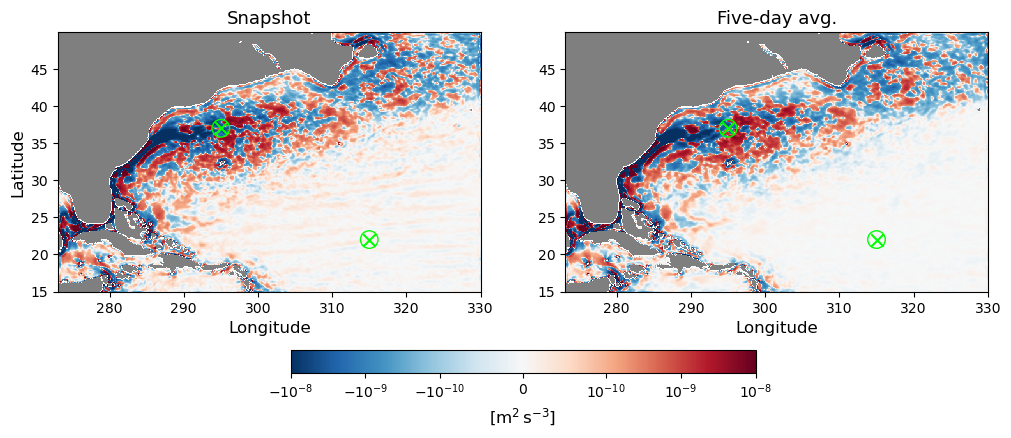

In [13]:
rho0 = 999.8
fig, axes = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
# fig.set_tight_layout(True)

im = axes[0].pcolormesh(ds120.XC, ds120.YC, 
                        (ds120.Pi.isel(Z=1, time=slice(None,None)).mean(['nmemb','time']) 
                         # * rho0*1e6
                        ),
                        rasterized=True, cmap='RdBu_r',
                        # norm=clr.SymLogNorm(1e0, vmin=-5e1, vmax=5e1)
                        norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                       )
axes[1].pcolormesh(ds120.XC, ds120.YC, 
                   (dt120.Pi.isel(Z=1, time=slice(None,None)).mean(['nmemb','time']) 
                    # * rho0*1e6
                   ),
                   rasterized=True, cmap='RdBu_r',
                   # norm=clr.SymLogNorm(1e0, vmin=-5e1, vmax=5e1)
                   norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                  )

axes[0].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=1),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[1].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=1),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )

for reg in range(6):
    if reg == 0 or reg == 5:
        axes[0].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[0].scatter(xs[reg], ys[reg], marker='o', s=160, 
                        facecolors='none', edgecolors='lime')
        axes[1].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[1].scatter(xs[reg], ys[reg], marker='o', s=160, 
                        facecolors='none', edgecolors='lime')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

axes[0].set_ylabel(r"Latitude", fontsize=12)
axes[0].set_xlabel(r"Longitude", fontsize=12)
axes[1].set_xlabel(r"Longitude", fontsize=12)

axes[0].set_title(r"Snapshot", fontsize=13)
axes[1].set_title(r"Five-day avg.", fontsize=13)

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', shrink=.5)
# cbar.set_label(r"[$\mu$W$\,/\,$m$^3$]", fontsize=12)
cbar.set_label(r"[m$^2\,$s$^{-3}$]", fontsize=12)

plt.savefig(op.join(spec,'Figs/Aluie-TotPi-diag_Z452.pdf'))

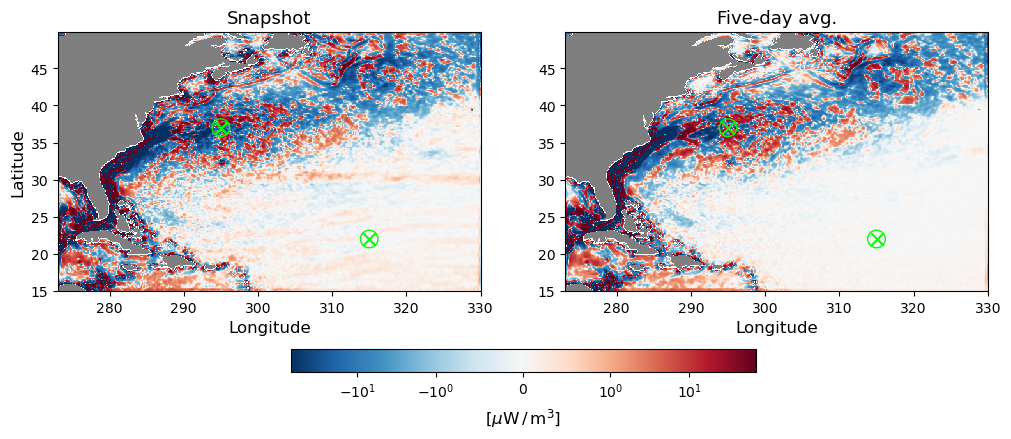

In [12]:
rho0 = 999.8
fig, axes = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
# fig.set_tight_layout(True)

im = axes[0].pcolormesh(ds120.XC, ds120.YC, 
                        (ds120.Pi.isel(Z=0, time=slice(None,None)).mean(['nmemb','time']) 
                         * rho0*1e6
                        ),
                        rasterized=True, cmap='RdBu_r',
                        norm=clr.SymLogNorm(1e0, vmin=-7e1, vmax=7e1)
                        # norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                       )
axes[1].pcolormesh(ds120.XC, ds120.YC, 
                   (dt120.Pi.isel(Z=0, time=slice(None,None)).mean(['nmemb','time']) 
                    * rho0*1e6
                   ),
                   rasterized=True, cmap='RdBu_r',
                   norm=clr.SymLogNorm(1e0, vmin=-7e1, vmax=7e1)
                   # norm=clr.SymLogNorm(1e-10, vmin=-1e-8, vmax=1e-8)
                  )

axes[0].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=0),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )
axes[1].pcolormesh(dsb.XC, dsb.YC, dsb.maskC.where(dsb.maskC!=1.).isel(Z=0),
                     cmap='binary', vmin=-1.5, vmax=1.5, rasterized=True
                    )

for reg in range(6):
    if reg == 0 or reg == 5:
        axes[0].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[0].scatter(xs[reg], ys[reg], marker='o', s=160, 
                        facecolors='none', edgecolors='lime')
        axes[1].scatter(xs[reg], ys[reg], marker='x', s=80, c='lime')
        axes[1].scatter(xs[reg], ys[reg], marker='o', s=160, 
                        facecolors='none', edgecolors='lime')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

axes[0].set_ylabel(r"Latitude", fontsize=12)
axes[0].set_xlabel(r"Longitude", fontsize=12)
axes[1].set_xlabel(r"Longitude", fontsize=12)

axes[0].set_title(r"Snapshot", fontsize=13)
axes[1].set_title(r"Five-day avg.", fontsize=13)

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', shrink=.5)
cbar.set_label(r"[$\mu$W$\,/\,$m$^3$]", fontsize=12)
# cbar.set_label(r"[m$^2\,$s$^{-3}$]", fontsize=12)

plt.savefig(op.join(spec,'Figs/Aluie-TotPi-diag_Z000.pdf'))